# Overview of the steps this code will take:
### 1. load in the data
### 2. shorten to X, Y coordinates
### 3. calculate PCA, and drop nulls
### 4. Seperate the datas into colored and grey
### 5. Define Elipses function
### 6. Plot. 

In [53]:
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches

# Defining function to caluculate 95% confidence interval and create ellipse
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

After importing all the necessary packages, load in the data as a csv. This file contains all the x,y points for each of the species, but importantly, PCs have not been calculated yet. We will do this using sklearn later.

In [54]:
#load in the data
df = pd.read_csv('Modeled_reformatted.csv')

Before we can calculate the PCs, we need to clean up the data frame a little so that the function can recognize what data to use. In this case, we need to hide the columns that have information that ISNT x, y data. This will leave a dataframe that has only the x, y points. Importantly, since we are not changing the order of the data, it will be easy to put those columns we took out back in later. We will need that information later to determine what the values pertain to.

In [55]:
# for PCA we want only the columns with x,y coordinate data
#df = df.drop(columns = ['vine', 'vine_year', 'year', 'species'])
short_df = df.iloc[:,5:]

##This is the df without the masked out species, and cutting off the first 5 columns.

Now that we have properly formated the data, we can calculate the PCs. The package ski kit learn has a function that will easily do this for us. For now, we only want to see PC1 and PC2, so the number of components (n_components) can be set to 2. We can also see the the percent of variance in the data explained by the PCs by the function pca.explained_variance_ratio_).
I THINK BECAUSE THIS DATA ISNT BEING MODELED, WE DO NOT NEED TO SCALE IT. 

The next function, pca.fit_transform will take our cleaned data and calculate the PC values for PC1 & PC2. Then we can put those values into a data frame, and concatentate our new PC dataframe to the original dataframe (not the cleaned version) by row. This way we have all the species and variable data, along with the x,y coordinates, and their corresponding PC values.

In [56]:
## From Passiflora Notebook

#Now for the PCA. We will be using PCA from the scikit learn module. 
#We first call up PCA using the `PCA()` function, and specify how many PCs to return. 
#To make it simple for now, let's only return the first two PCs. 

pca = PCA(n_components=2)

#We then use `.fit_transform()` to perform the PCA on our data and return the principal components
#We then convert the PCs into a `pandas` dataframe to use later.

real_PCs = pca.fit_transform(short_df)
real_PCs_df = pd.DataFrame(data = real_PCs, columns = ['PC1', 'PC2'])

#Finally, we concatenate our PCs with the original dataframe. 
#This will put the species information back together again with the PCs so that we can plot it. 
#The axis=1 refers to concatenating the columns, not the rows.

df_pc = pd.concat([df, real_PCs_df], axis = 1)
df_pc = df_pc.dropna()

pca.explained_variance_ratio_

array([0.29927767, 0.1601779 ])

Before we plot, we want to format the data a little more so that it is easier to visualize in the way that we want. We will make 2 dataframes: one that contains only the species we want to highlight, and the second that contains all the species EXCEPT those that are already in the first df. 

In [60]:
#Separate the species we want to have colors for into individual data frames
cinerea = df_pc[ df_pc['species']=="Vitis_cinerea" ]
riparia = df_pc[ df_pc['species']=="Vitis_riparia" ]
rupestris = df_pc[ df_pc['species']=="Vitis_rupestris" ]
ampel = df_pc[df_pc['species']=="Ampelopsis_brevipedunculata" ]

#makes a list of the dataframes (masked from above) to concat
elipse_df = (riparia, rupestris, cinerea, ampel)

#adds these dataframes together keeping common columns (just add more rows to the bottom)
#this is the DF we will pass through the elipses function. 
df_el = pd.concat(elipse_df)

#we also want to drop these species from df_pc, so that we can plot them with seperate conditions (color, size, alpha, etc)
df_grey = df_pc[~df_pc['species'].isin(['Vitis_cinerea', 'Vitis_riparia', 'Vitis_rupestris', 'Ampelopsis_brevipedunculata'])]

#so now the working dfs are df_el and df_grey. We will use those from now on.

Explanation of Confidence elipses copied directly from https://stats.stackexchange.com/questions/217374/real-meaning-of-confidence-ellipse :

A confidence ellipse has to do with unobserved population parameters, like the true population mean of your 
bivariate distribution. A 95% confidence ellipse for this mean is really an algorithm with the following property: 
if you were to replicate your sampling from the underlying distribution many times and each time calculate a 
confidence ellipse, then 95% of the ellipses so constructed would contain the underlying mean. (Note that each 
sample would of course yield a different ellipse.)
    
    
Size of the confidence interval for the regression estimate, ci = 95%

Before we plot the PC values, we need to make confidence elipses for the species that we want to see. We will be using the df_el df for this function when we call it later. 

This code can was taken from https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py and can also be found on CarstenSchelp/plot_confidence_ellipse.py on github

In [61]:
## From Midterm Group 1

def confidence_ellipse(x, y, ax, n_std=3.0, edgecolor='none', facecolor='none', **kwargs):

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        edgecolor=edgecolor,
        facecolor=facecolor,              
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

Now it is time to plot the data. We plot the colored and grey datasets seperately, but on the same graph. This way, the grey is set to be smaller and lighter, while the colored points are big and bright. This also allows us to run only the colored data through the elipses function, thus only plotting those elipses. 

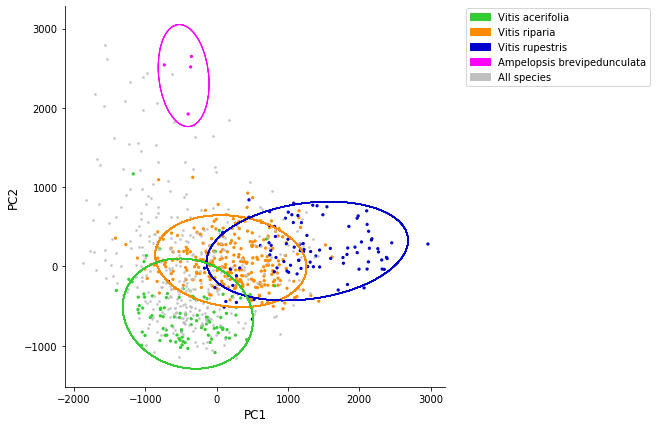

In [63]:
## from Midterm group 1
# Make a plot of PC1 vs PC2 with species colored

# Extract values from colored dataset 
xvalues = df_el['PC1']
yvalues = df_el['PC2']
color =  df_el['species']

# From a dataframe with extracted values
df = pd.DataFrame(dict(xvalues=xvalues, yvalues=yvalues, color=color))

# Start creating subplot
fig, ax = plt.subplots(figsize=(7, 7))

# Create dictionary to set colors to species
colors = {'Vitis_cinerea':'limegreen',
          'Vitis_riparia':'darkorange',
          'Vitis_rupestris':'mediumblue',
         'Ampelopsis_brevipedunculata':'magenta'}

# Create confidence intervals for each species using for loop and confidence_ellipse function
# again, only doing this for the el df.
for i in df_el['species']:
    
    xvalues = df_el[df_el['species'] == i]['PC1']
    yvalues = df_el[df_el['species'] == i]['PC2']
    color = colors.get(i)
    
    confidence_ellipse(x = xvalues, y = yvalues, ax = ax, n_std = 1.960, edgecolor = color)

    
# Build the legend
patch1 = mpatches.Patch(color='limegreen', label='Vitis acerifolia')
patch2 = mpatches.Patch(color='darkorange', label='Vitis riparia')
patch3 = mpatches.Patch(color='mediumblue', label='Vitis rupestris')
patch4 = mpatches.Patch(color='magenta', label='Ampelopsis brevipedunculata')
patch5 = mpatches.Patch(color='silver', label='All species')
# Set up for handles declaration
patches = [patch1, patch2, patch3, patch4, patch5]
# Add legend to plot, borderaxespad and bbox are just aethetic adjustments to the placement of the legend.
legend = ax.legend(handles=patches, loc=2, borderaxespad=0.2, bbox_to_anchor=(1.05, 1))
                       
# Make scatter plot with extracted values and define point colors by species
# since all the species in the grey dataset are the same, we didnt have to go through all those steps. 
   #we simply call the grey color in the function.
ax.scatter(df['xvalues'], df['yvalues'], c=df['color'].apply(lambda x: colors[x]), s=5)
ax.scatter(df_grey['PC1'], df_grey['PC2'], c = 'silver', s = 3, alpha = 0.8)

# Set axis labels
ax.set_xlabel('PC1', fontsize = 12)
ax.set_ylabel('PC2', fontsize = 12)

# Remove top and right spines from plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make the plot square
ax.set_aspect(1./ax.get_data_ratio())

# Save figure
plt.savefig('Final_PCA_Modeled_Species.tif', bbox_inches="tight", dpi=600)

# Show plot
plt.show()

The end.

## This is just to see how all the species are distributed

In [19]:
df_pc.columns

Index(['vine', 'vine_year', 'year', 'species', 'x1_1', 'x1_2', 'x1_3', 'x1_4',
       'x1_5', 'x1_6',
       ...
       'y21_3', 'y21_4', 'y21_5', 'y21_6', 'y21_7', 'y21_8', 'y21_9', 'y21_10',
       'PC1', 'PC2'],
      dtype='object', length=426)

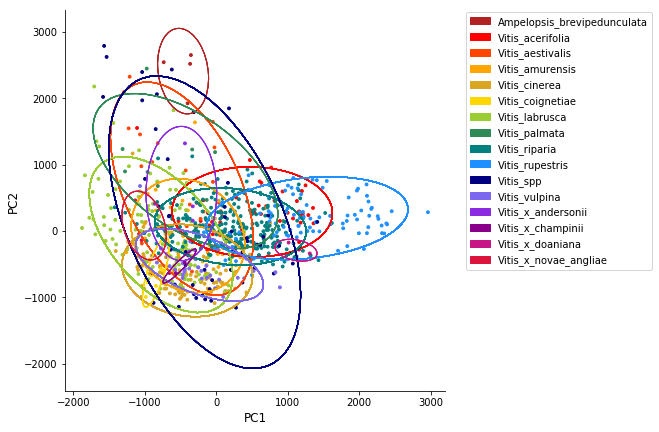

In [21]:
## from Midterm group 1
# Make a plot of PC1 vs PC2 with species colored

# Extract values from colored dataset 
xvalues = df_pc['PC1']
yvalues = df_pc['PC2']
color =  df_pc['species']

# From a dataframe with extracted values
df = pd.DataFrame(dict(xvalues=xvalues, yvalues=yvalues, color=color))

# Start creating subplot
fig, ax = plt.subplots(figsize=(7, 7))

# Create dictionary to set colors to species
colors = {'Ampelopsis_brevipedunculata':'firebrick', 
          'Vitis_acerifolia':'red',
          'Vitis_aestivalis':'orangered',
          'Vitis_amurensis':'orange',
          'Vitis_cinerea':'goldenrod',
          'Vitis_coignetiae':'gold',
          'Vitis_labrusca':'yellowgreen',
          'Vitis_palmata':'seagreen',
          'Vitis_riparia':'teal', 
          'Vitis_rupestris':'dodgerblue', 
          'Vitis_spp':'navy', 
          'Vitis_vulpina':'mediumslateblue',
          'Vitis_x_andersonii':'blueviolet', 
          'Vitis_x_champinii':'darkmagenta', 
          'Vitis_x_doaniana':'mediumvioletred',
          'Vitis_x_novae_angliae':'crimson'}

# Create confidence intervals for each species using for loop and confidence_ellipse function
# again, only doing this for the el df.
for i in df_pc['species']:
    
    xvalues = df_pc[df_pc['species'] == i]['PC1']
    yvalues = df_pc[df_pc['species'] == i]['PC2']
    color = colors.get(i)
    
    confidence_ellipse(x = xvalues, y = yvalues, ax = ax, n_std = 1.960, edgecolor = color)

    
# Build the legend
patch1 = mpatches.Patch(color='firebrick', label='Ampelopsis_brevipedunculata')
patch2 = mpatches.Patch(color='red', label='Vitis_acerifolia')
patch3 = mpatches.Patch(color='orangered', label='Vitis_aestivalis')          
patch4 = mpatches.Patch(color='orange', label='Vitis_amurensis')
patch5 = mpatches.Patch(color='goldenrod', label='Vitis_cinerea')
patch6 = mpatches.Patch(color='gold', label='Vitis_coignetiae')
patch7 = mpatches.Patch(color='yellowgreen', label='Vitis_labrusca')
patch8 = mpatches.Patch(color='seagreen', label='Vitis_palmata')
patch9 = mpatches.Patch(color='teal', label='Vitis_riparia')                        
patch10 = mpatches.Patch(color='dodgerblue', label='Vitis_rupestris')
patch11 = mpatches.Patch(color='navy', label='Vitis_spp')
patch12 = mpatches.Patch(color='mediumslateblue', label='Vitis_vulpina')                        
patch13 = mpatches.Patch(color='blueviolet', label='Vitis_x_andersonii')                        
patch14 = mpatches.Patch(color='darkmagenta', label='Vitis_x_champinii')
patch15 = mpatches.Patch(color='mediumvioletred', label='Vitis_x_doaniana')                        
patch16 = mpatches.Patch(color='crimson', label='Vitis_x_novae_angliae')                        
                        
                        
                        
# Set up for handles declaration
patches = [patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, 
           patch13, patch14, patch15, patch16]
# Add legend to plot, borderaxespad and bbox are just aethetic adjustments to the placement of the legend.
legend = ax.legend(handles=patches, loc=2, borderaxespad=0.2, bbox_to_anchor=(1.05, 1))
                       
# Make scatter plot with extracted values and define point colors by species
# since all the species in the grey dataset are the same, we didnt have to go through all those steps. 
   #we simply call the grey color in the function.
#ax.scatter(df_grey['PC1_2'], df_grey['PC2_2'], c = 'silver', s = 3, alpha = 0.8)
ax.scatter(df['xvalues'], df['yvalues'], c=df['color'].apply(lambda x: colors[x]), s=8)

# Set axis labels
ax.set_xlabel('PC1', fontsize = 12)
ax.set_ylabel('PC2', fontsize = 12)

# Remove top and right spines from plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make the plot square
ax.set_aspect(1./ax.get_data_ratio())

# Save figure
#plt.savefig('Final_PCA_ALL_Species.tif', bbox_inches="tight", dpi=600)

# Show plot
plt.show()